Missing values per column:
 X1              0
X2              0
X3              0
X4              0
X5              0
X6              0
X7              0
X8              0
Heating Load    0
dtype: int64
Duplicates count: 0
Shape after duplicates removal: (768, 9)


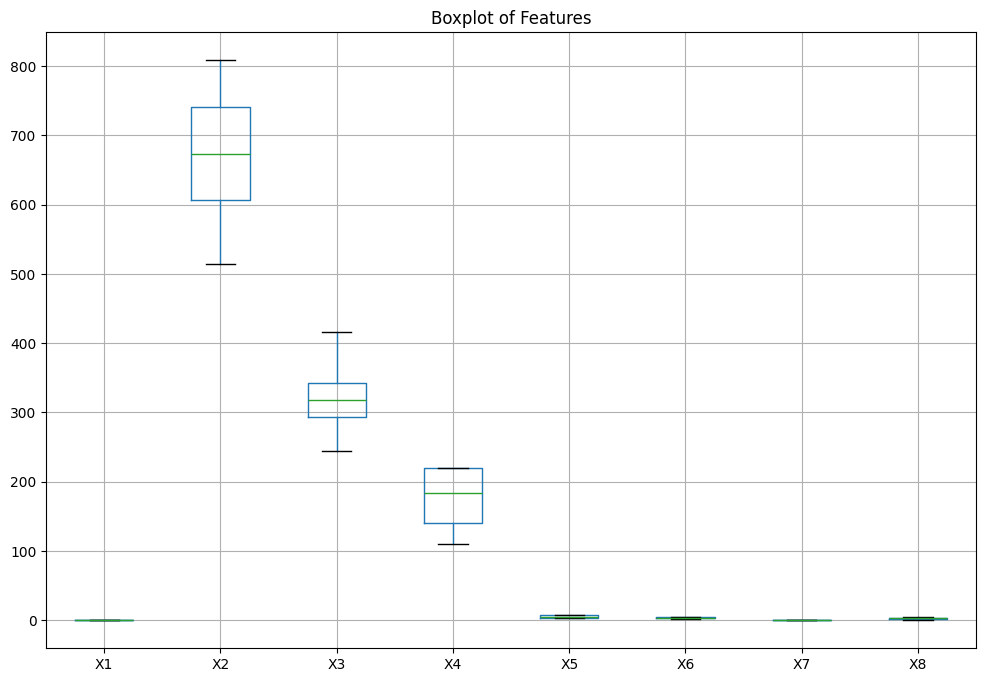

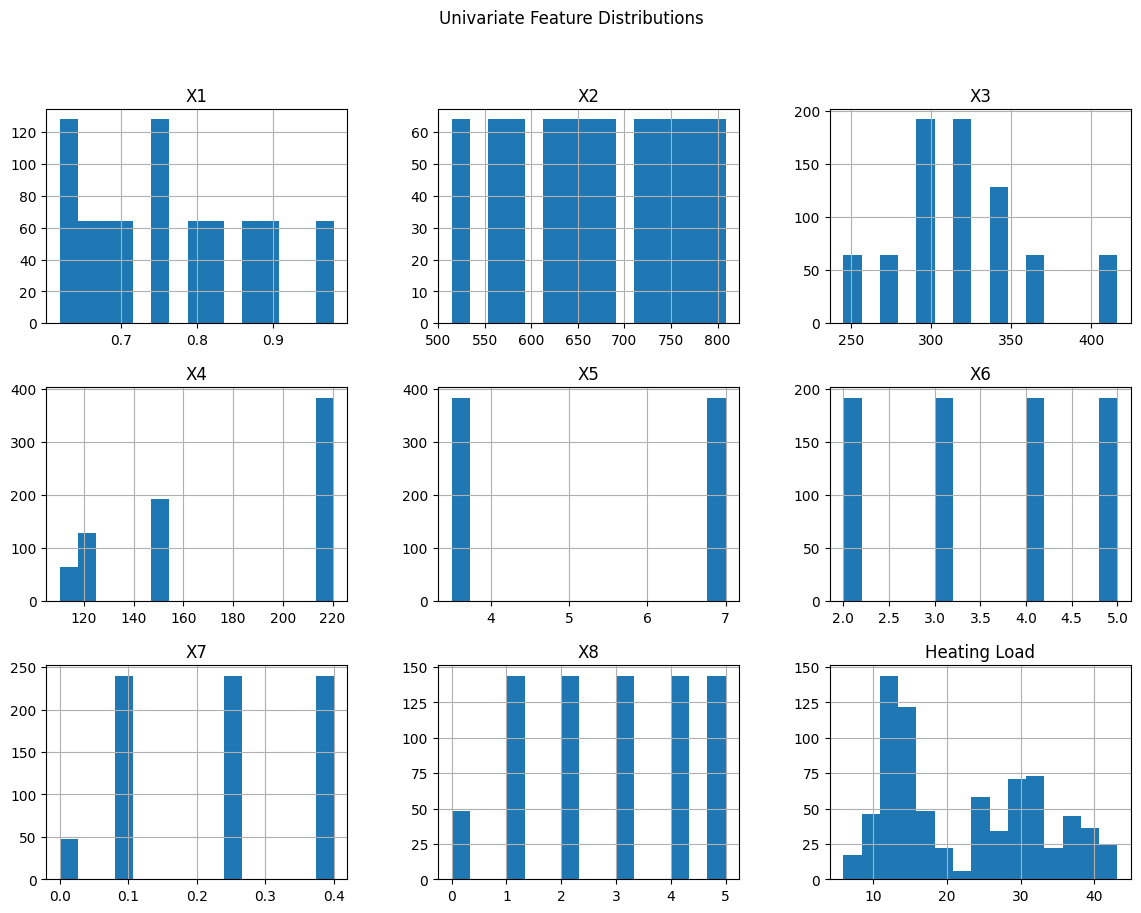

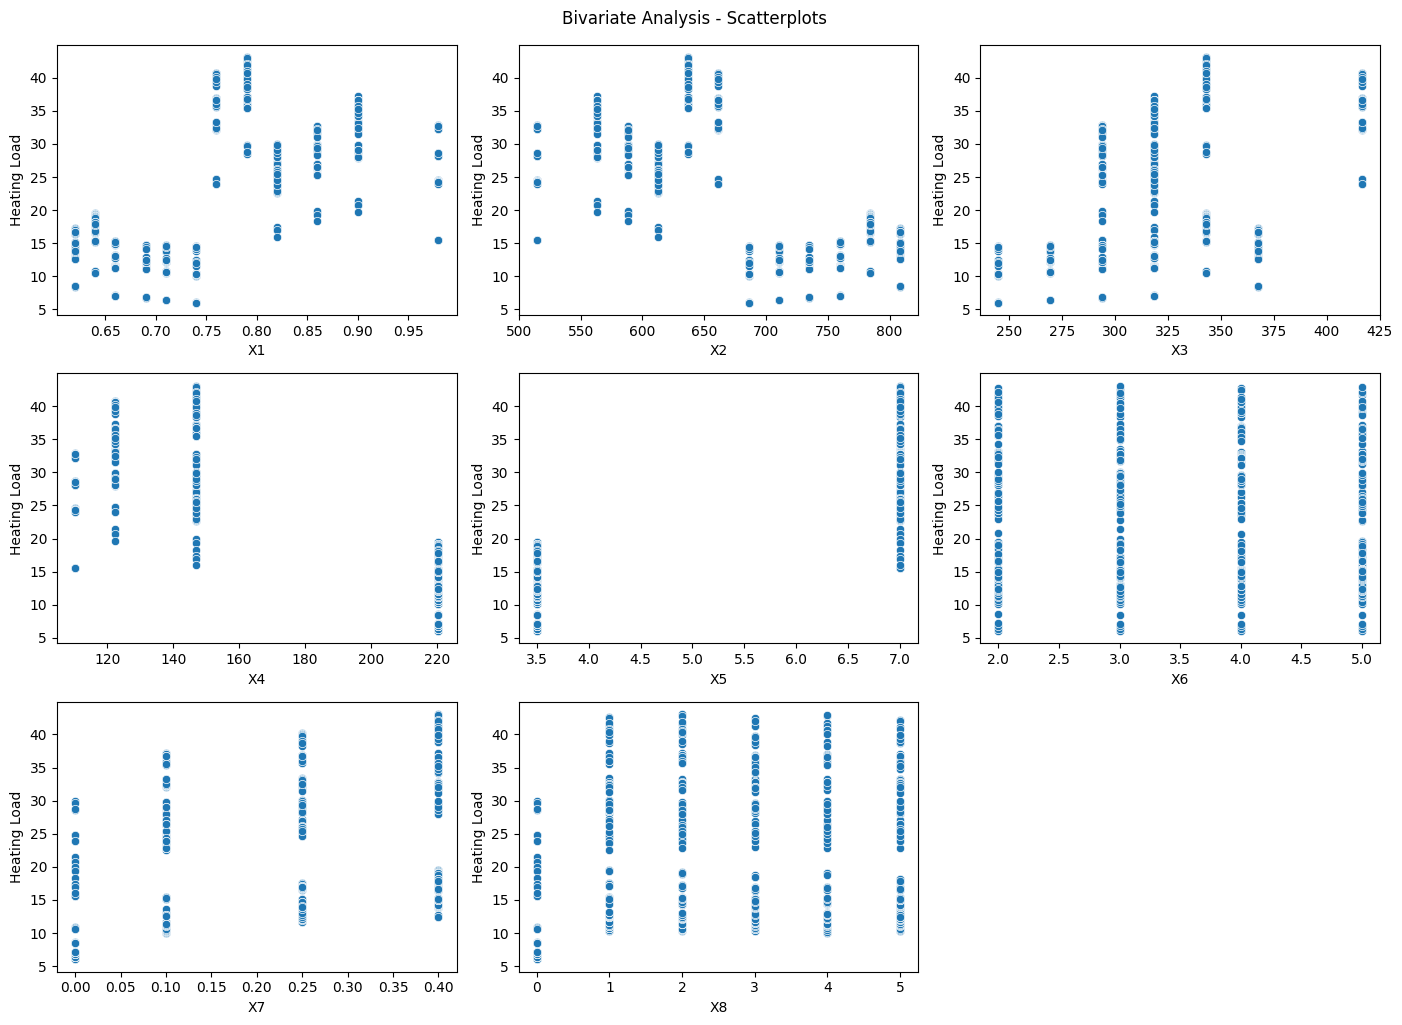

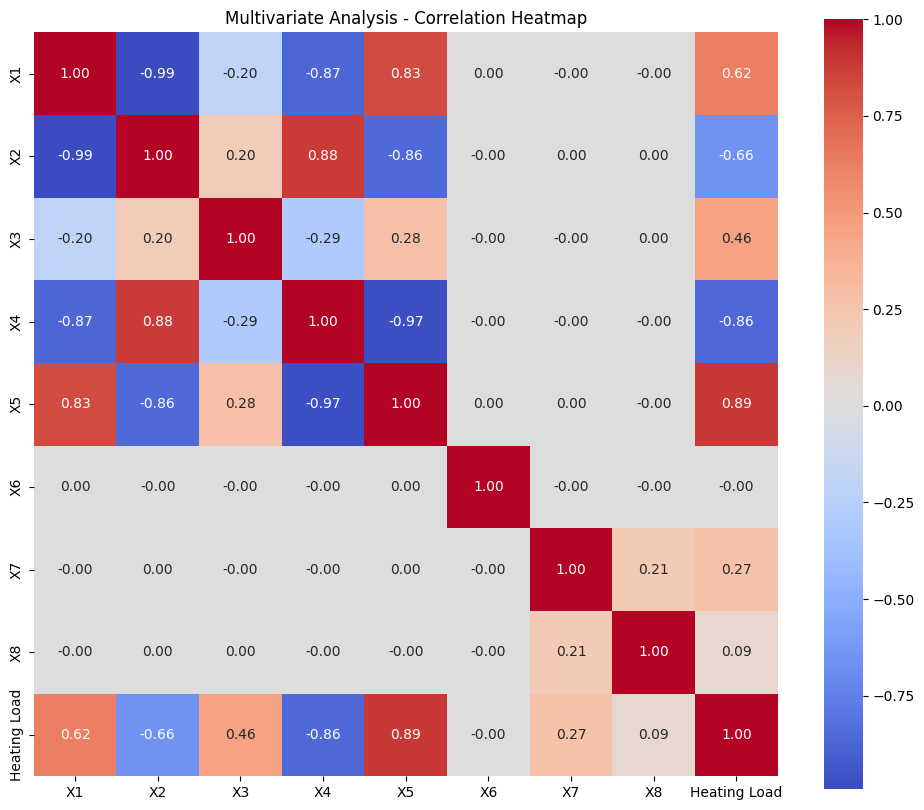

Linear Regression - RMSE: 3.0254, MAE: 2.1820, R2: 0.9122
Gradient Boosting - RMSE: 0.5151, MAE: 0.3862, R2: 0.9975
Random Forest - RMSE: 0.4944, MAE: 0.3517, R2: 0.9977
CatBoost - RMSE: 0.3353, MAE: 0.2398, R2: 0.9989

Model Performance Comparison:
                       RMSE       MAE        R2
CatBoost           0.335253  0.239839  0.998922
Random Forest      0.494396  0.351743  0.997655
Gradient Boosting  0.515084  0.386159  0.997455
Linear Regression  3.025424  2.182047  0.912184


/tmp/ipython-input-3842165586.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y='R2', data=results_df, palette='viridis')


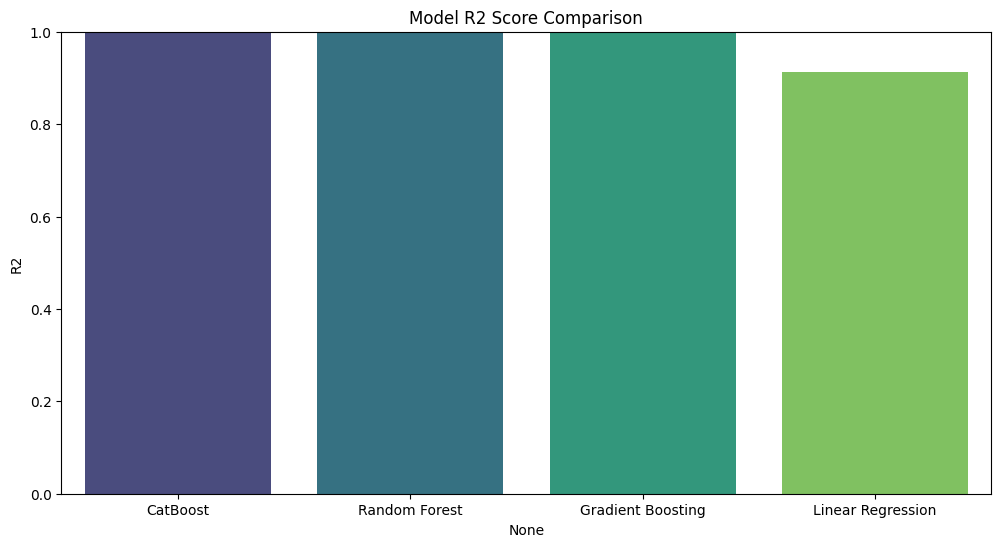

/tmp/ipython-input-3842165586.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y='RMSE', data=results_df, palette='magma')


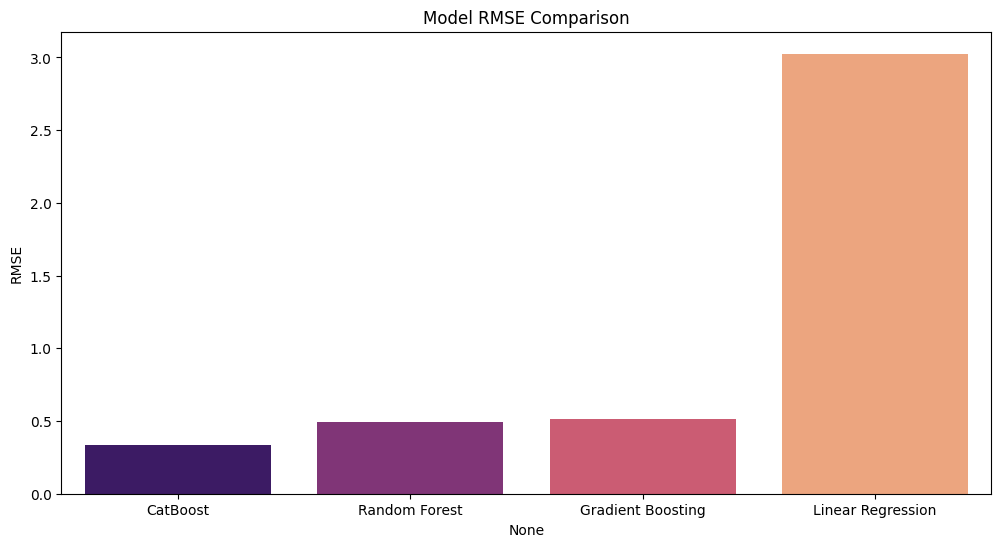

/tmp/ipython-input-3842165586.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y='MAE', data=results_df, palette='coolwarm')


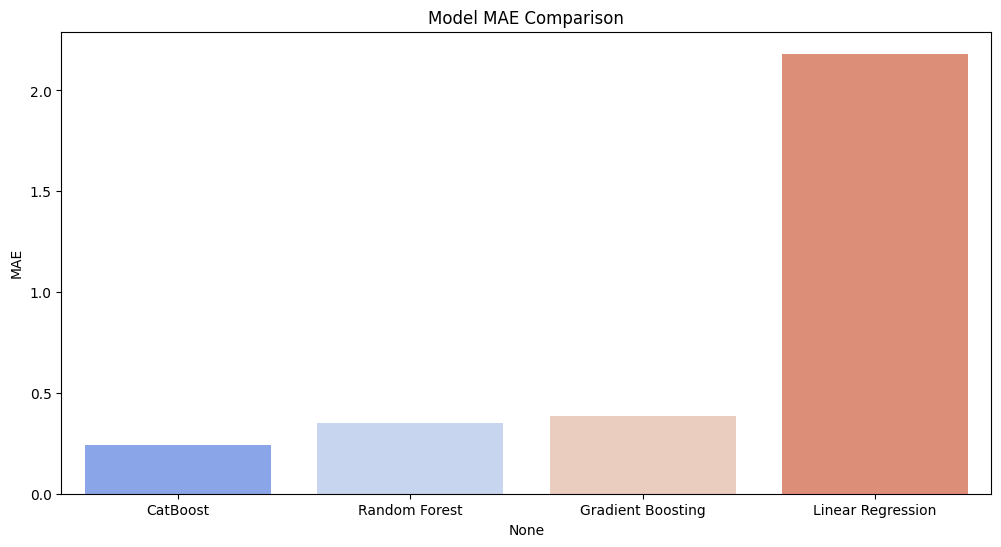

Best model based on R2 score: CatBoost


['best_energy_efficiency_model.pkl']

In [ ]:
# Import necessary libraries
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

# Load Energy Efficiency data from UCI repository
energy_efficiency = fetch_ucirepo(id=242)

# Fix feature names if None
if energy_efficiency.data.feature_names is None:
    feature_names = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
else:
    feature_names = energy_efficiency.data.feature_names

X = energy_efficiency.data.features
y = energy_efficiency.data.targets['Y1']  # Heating Load
# X1: Relative Compactness
# X2: Surface Area
# X3: Wall Area
# X4: Roof Area
# X5: Overall Height
# X6: Orientation (1 to 4, categorical integer representing cardinal directions)
# X7: Glazing Area
# X8: Glazing Area Distribution (1 to 5, categorical integer indicating distribution type)

# Create DataFrame for EDA and preprocessing
df = pd.DataFrame(X, columns=feature_names)
df['Heating Load'] = y

# EDA
# Missing values
print("Missing values per column:\n", df.isnull().sum())

# Duplicates
print("Duplicates count:", df.duplicated().sum())
df = df.drop_duplicates()
print("Shape after duplicates removal:", df.shape)

# Outlier identification
plt.figure(figsize=(12,8))
df.boxplot(column=feature_names)
plt.title("Boxplot of Features")
plt.show()

# Outlier handling (IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_capped = df.copy()
for col in feature_names:
    df_capped[col] = np.where(df_capped[col] < lower[col], lower[col],
                              np.where(df_capped[col] > upper[col], upper[col], df_capped[col]))

# Univariate analysis
df_capped.hist(figsize=(14,10), bins=15)
plt.suptitle("Univariate Feature Distributions")
plt.show()

# Bivariate analysis
plt.figure(figsize=(14, 10))
for i, col in enumerate(feature_names):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(x=df_capped[col], y=df_capped['Heating Load'])
    plt.xlabel(col)
    plt.ylabel('Heating Load')
plt.tight_layout()
plt.suptitle('Bivariate Analysis - Scatterplots', y=1.02)
plt.show()

# Multivariate analysis
plt.figure(figsize=(12,10))
sns.heatmap(df_capped.corr(), annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Multivariate Analysis - Correlation Heatmap')
plt.show()

# Feature scaling
X_features = df_capped.drop('Heating Load', axis=1)
y_target = df_capped['Heating Load']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_target, test_size=0.2, random_state=42)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0)
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

# Results table
results_df = pd.DataFrame(results).T.sort_values('R2', ascending=False)
print("\nModel Performance Comparison:")
print(results_df)

# Visualize performance metrics
plt.figure(figsize=(12,6))
sns.barplot(x=results_df.index, y='R2', data=results_df, palette='viridis')
plt.title('Model R2 Score Comparison')
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x=results_df.index, y='RMSE', data=results_df, palette='magma')
plt.title('Model RMSE Comparison')
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x=results_df.index, y='MAE', data=results_df, palette='coolwarm')
plt.title('Model MAE Comparison')
plt.show()

# Select best model
best_model_name = results_df.index[0]
print(f"Best model based on R2 score: {best_model_name}")

# Save best model
joblib.dump(models[best_model_name], 'best_energy_efficiency_model.pkl')
